## Création d'un pipeline et d'un  workflow

Un pipeline qui s'exécute automatiquement dans un workflow, à travers différentes étapes, détectera les problèmes tôt et aidera votre équipe à collaborer de la manière la plus efficace. 

Dans ce guide, nous suivrons les pratiques d'intégration continue, en exécutant le pipeline automatiquement et à chaque changement, pour être sûr que tout notre code suit des normes de qualité élevées, et qu'il s'exécute et passe tous les tests. Nous préparons également un conteneur prêt à être mis en production.

Dans ce chapitre, nous aborderons les sujets suivants : 

* Comprendre les pratiques d'intégration continue 
* Configurer Travis CI 
* Configurer GitHub 
* Pousser les images Docker à partir de Travis 


By the end of the chapter, you'll know how to automatically run tests on every code changeand how to create a safety net that will allow you to develop faster and more efficiently

À la fin du guide, vous saurez comment exécuter automatiquement des tests sur chaque changement de code et comment créer un filet de sécurité qui vous permettra de développer plus rapidement et plus efficacement

## Comprendre les pratiques d'intégration continue 

L'intégration continue (généralement abrégée en CI) est une série de pratiques d'ingénierie logicielle qui garantissent que le code est toujours dans un état de fonctionnement. 

Le terme intégration continue vient du fait qu'historiquement, il fallait intégrer des logiciels fréquemment, souvent plusieurs fois par jour. Cela est dû au fait que les développeurs travaillaient avec du code local qui n'était pas nécessairement associé automatiquement au code d'autres personnes. 

De nos jours, l'utilisation d'un logiciel de gestion des versions de contrôle de source tel que Git rend certains des éléments automatiquement disponibles.

L'intégration continue met l'accent sur le fait d'avoir du code potentiellement publiable à tout moment. Cela rend les versions possibles très souvent, avec de petits incréments de code



    Faire plus de versions plus souvent génère en fait une augmentation de la
    qualité de chaque version. Plus de déploiements signifient également que
    chaque déploiement est plus petit, ce qui réduit la possibilité d'un gros
    problème. Même si cela semble contre-intuitif, un déploiement plus rapide
    est fortement corrélé à une meilleure qualité des déploiements et à moins
    de problèmes de production.


    L'objectif ici est de pouvoir augmenter la vitesse de déploiement. Mais
    pour cela, nous devons être sûrs de construire un bon filet de sécurité qui
    vérifie (automatiquement) que ce que nous faisons peut être diffusé en
    toute sécurité. C'est là que toutes les pratiques d'IC ​​entrent en jeu.

Il est tout à fait possible, après avoir mis en place tous les processus et l'infrastructure, d'implémenter des releases plusieurs fois par jour (en supposant que le code soit généré assez rapidement). Cela peut prendre du temps pour y arriver, mais assurez-vous de prendre votre temps pour comprendre le processus et de produire tous les outils nécessaires pour être certain de gagner en vitesse sans sacrifier la stabilité. Et, croyez-moi, c'est tout à fait réalisable !




## Produire des builds automatisés 

L'élément central de CI est de générer des builds automatisés intégrés à un système de contrôle de source. Une version logicielle est un processus qui (à partir du code source) effectue une série d'actions et produit une sortie. Si le projet est écrit dans un langage compilé, la sortie sera généralement le programme compilé.

Si nous voulons avoir un logiciel de qualité, une partie de la construction consiste à vérifier que le code produit respecte les normes du code. Si le code ne respecte pas ces normes, alors le build renverra une erreur.


    Une façon courante de décrire les erreurs sur une construction est de dire
    que la construction est cassée. Une construction peut se briser de
    différentes manières, et certains types d'erreurs peuvent l'arrêter plus
    tôt (comme une erreur de compilation avant d'exécuter des tests) ou nous
    pouvons continuer à détecter d'autres problèmes (comme l'exécution de tous
    les tests pour renvoyer toutes les erreurs possibles).

Voici quelques exemples d'étapes pouvant faire partie de la construction :

*  Compilation du code


    Python n'a généralement pas besoin d'être compilé, mais cela peut être
    nécessaire si vous utilisez des extensions C (modules écrits en C et
    importés de Python : https://docs.python.org/3/extending/) ou des outils tels que Cython

* Exécution de tests unitaires
* Exécution d'outils d'analyse de code statique
* Création d'un ou plusieurs conteneurs
* Vérification des dépendances pour les vulnérabilités connues avec un outil tel que Safety
* Génération d'un package binaire ou source pour la distribution. Par exemple, RPM
* Exécuter d'autres types de tests
* Générer des rapports, des diagrammes ou d'autres actifs à partir du code


Tout ce qui peut s'exécuter automatiquement peut faire partie d'un build. Un build local peut être généré à tout moment, même avec du code toujours en cours. Ceci est important pour le débogage et la résolution des problèmes. Mais les builds automatisés s'exécuteront sur chaque commit individuel, et non à une étape intermédiaire. Cela rend très explicite la vérification du code qui devrait s'exécuter en production et du code encore en cours d'exécution.


    Notez qu'un seul commit peut encore être en cours, mais il vaudra quand
    même la peine d'être commité. Peut-être qu'il s'agit d'une seule étape vers
    une fonctionnalité, que plusieurs personnes travaillent sur la même partie
    du code, ou que cela s'étale sur plusieurs jours et que le code est poussé
    à la fin de la journée. Peu importe, chaque commit est une étape
    reproductible qui peut être construit et vérifié si la construction est
    réussie ou non


L'exécution du build pour chaque commit détecte les problèmes très rapidement. Si les commits sont petits, un changement de rupture est facile à identifier. Cela permet également d'annuler facilement les modifications qui cassent la construction et de revenir au code de travail connu

## Connaître les avantages de l'utilisation de Docker pour les builds 

L'un des principaux problèmes traditionnels avec les builds était d'avoir un environnement de build adéquat avec toutes les dépendances nécessaires pour exécuter la build complète. Cela peut inclure des éléments tels que le compilateur, le cadre de test pour exécuter les tests, tous les outils d'analyse statique et le gestionnaire de packages. Une divergence dans les versions pourrait également produire des erreurs


Comme nous l'avons vu auparavant, Docker est un moyen fantastique d'encapsuler notre logiciel. Cela nous permet de créer une image qui contient à la fois notre code et tous les outils capables de procéder à toutes les étapes.

Dans le guide précédent, nous avons vu comment exécuter des tests unitaires en une seule commande, basé sur une image de construction. L'image elle-même peut exécuter ses propres tests unitaires. Cela fait abstraction de l'environnement de test et le définit explicitement. La seule dépendance nécessaire ici est d'avoir Docker installé.

Gardez à l'esprit qu'une seule version peut générer plusieurs images et les faire fonctionner sans coordination. Nous avons vu comment exécuter des tests unitaires dans le guide précédent - en générant serviceimage et une image de base de données - mais il y a plus d'utilisations possibles. Par exemple, vous pouvez vérifier que le test s'exécute sur deux systèmes d'exploitation différents, en créant deux images à partir de chacun des systèmes d'exploitation ou de différentes versions de l'interpréteur Python, et en vérifiant si les tests réussissent dans chacun d'eux.


L'utilisation des images Docker permet une standardisation dans tous les environnements. Nous pouvons exécuter localement des images dans un environnement de développement, en utilisant les mêmes commandes que celles utilisées dans notre environnement automatisé. Cela simplifie la recherche de bogues et de problèmes, car il crée le même environnement, y compris un système d'exploitation encapsulé, partout où la construction est exécutée

Notez que nous n'avons pas nécessairement besoin de créer une seule étape qui exécute l'ensemble de la construction ; il peut s'agir de plusieurs commandes Docker, utilisant même différentes images. Mais l'exigence est qu'ils soient tous contenus dans Docker, le seul logiciel requis pour l'exécuter. Le produit principal d'une construction utilisant Docker est une image ou des images Docker. Nous aurons besoin de les marquer correctement, mais seulement si la construction est réussie.

## Tirer parti du concept de pipeline 

Les outils CI aident à clarifier la manière dont une construction doit se dérouler et à contourner le concept de pipeline. Un pipeline est un ensemble d'étapes. Si l'un d'entre eux échoue, le pipeline s'arrête.

Chaque étape du pipeline peut produire des éléments qui pourraient être utilisés à des étapes ultérieures ou qui sont disponibles en tant que produit final de la version complète. Ces derniers éléments sont appelés artefacts

Regardons un exemple de pipeline :

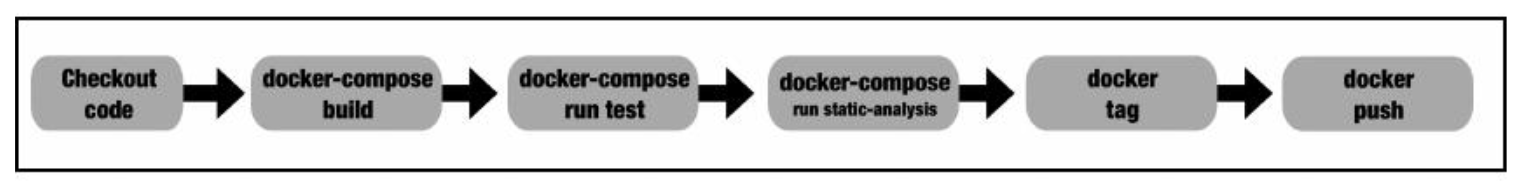

La première étape extrait le dernier commit du système de contrôle de source. Ensuite, nous construisons tous les conteneurs et exécutons à la fois les tests et l'analyse statique. Si tout s'est bien passé, nous étiquetons le conteneur de serveur résultant et l'envoyons au registre


    L'ordre dans lequel ces étapes s'exécutent doit être orienté vers la
    détection des problèmes le plus rapidement possible pour donner un retour
    rapide. Par exemple, si l'étape d'analyse statique est beaucoup plus rapide
    que l'étape de test, placer l'étape d'analyse en premier entraînera une fin
    de construction défaillante plus tôt. Soyez conscient des parties qui
    peuvent être exécutées plus tôt pour réduire le temps de rétroaction

Les outils CI permettent normalement une grande configuration dans les pipelines, y compris la possibilité d'exécuter différentes étapes en parallèle. Pour pouvoir exécuter des étapes en parallèle, elles doivent pouvoir être parallélisables, c'est-à-dire qu'elles ne doivent pas modifier les mêmes éléments.

Si l'outil CI choisi permet d'exécuter des étapes en parallèle, le pipeline peut être défini comme suit :

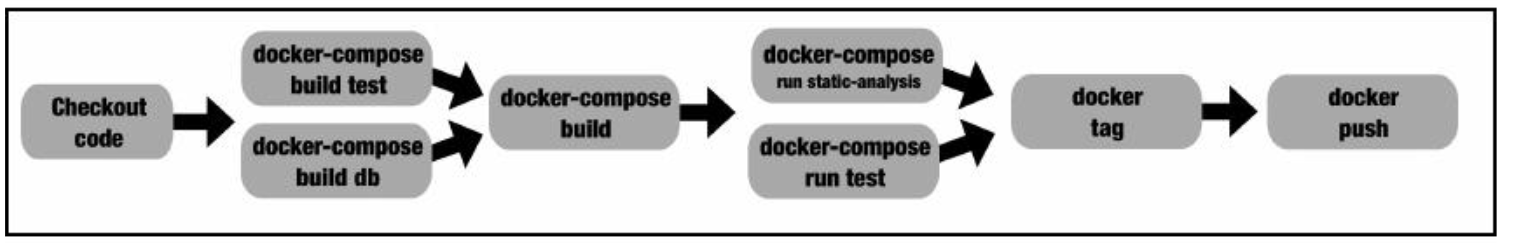

Notez que nous construisons la base de données et les images de test en parallèle. L'étape suivante construit le reste des éléments, qui sont déjà disponibles dans le cache, ce sera donc très rapide. Les tests et l'analyse statique peuvent s'exécuter en parallèle, dans deux conteneurs différents.

 Cela peut accélérer les builds complexes


    Assurez-vous de valider que le temps pris diminue. Il y a des cas où le
    temps pris sera très similaire. Par exemple, l'analyse statique peut être
    très rapide ou le matériel sur lequel vous l'exécutez peut ne pas être
    assez puissant pour construire des choses en parallèle, ce qui rend le
    temps de construction en parallèle et séquentiellement très similaire.
    Alors, validez toujours vos hypothèses.

Le pipeline est décrit dans un script spécifique à l'outil Travis CI. Nous verrons un exemple avec Travis CI plus tard.




## Brancher, fusionner et assurer une construction principale claire

Quand exécutons-nous une construction ? Chaque fois qu'un commit est poussé. Mais chaque résultat n'est pas le même. Lorsque nous traitons avec un système de contrôle de source tel que Git, nous avons généralement deux types de branches 

* Une branche principale
* Branches de fonctionnalité

Ils implémentent une fonctionnalité ou une correction de bogue particulière, qui sera fusionnée dans la branche principale lorsqu'elle sera prête, comme le montre la figure suivante :

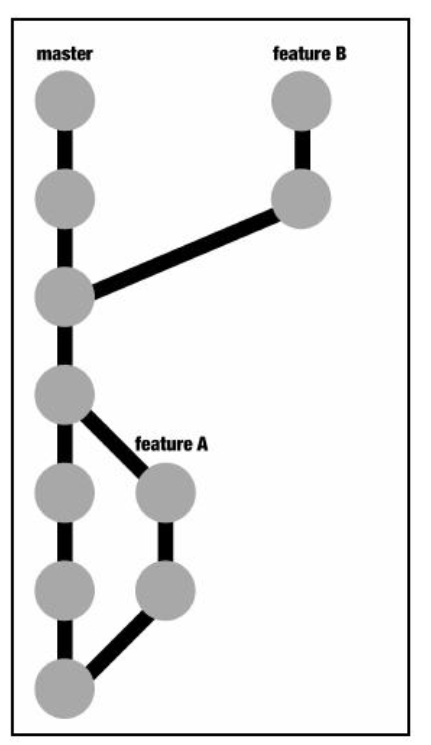

Dans cet exemple, nous voyons comment la branche principale (master) est ramifiée pour développer la fonctionnalité A. La fonctionnalité A est introduite brièvement après cela. Il y a une fonctionnalité B qui n'a pas encore été fusionnée car elle n'est pas prête. Avec les informations supplémentaires sur les builds qui ont réussi ou non, nous pouvons savoir quand il est sûr de fusionner une branche de fonctionnalité dans la branche principale :


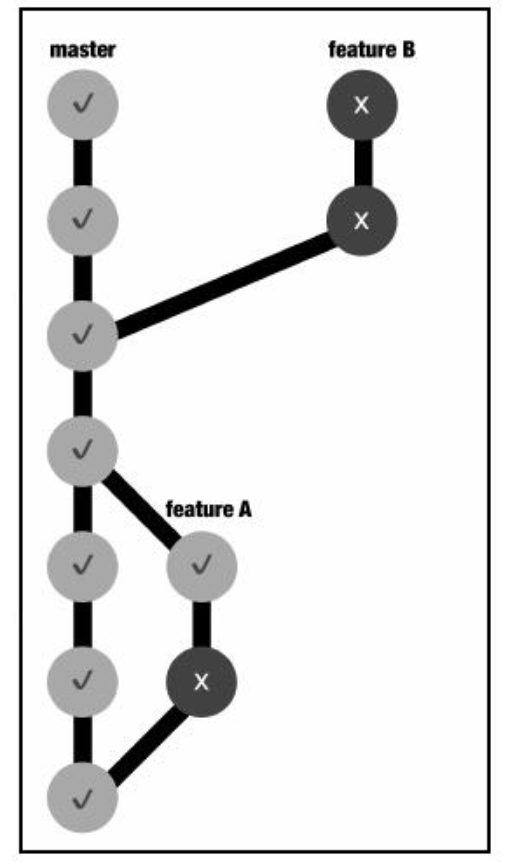

La rupture dans une branche de fonctionnalité qui n'est pas encore fusionnée n'est pas importante, mais pendant que le travail est en cours, cela devrait se produire. Pendant ce temps, une casse dans la branche principale est un événement qui doit être réparé dès que possible. Si la branche principale est en bon état, cela signifie qu'elle est potentiellement libérable.

GitHub a un modèle pour cela : les pull request. Nous allons configurer les demandes d'extraction pour vérifier automatiquement si la version a réussi et a évité la fusion ou non. Si nous forçons une branche de fonctionnalité à être également à jour avec la branche principale avant de fusionner, la branche principale finit par être très stable.

    Pour gérer les branches dans Git pour définir les versions, le modèle le
    plus populaire est Git-flow, défini dans cet article de blog influent
     (https://nvie.com/posts/a-successful-git-branching-modèle/  ). Les
    pratiques CI suivantes permettent de simplifier un peu les choses et ne
    traitent pas d'éléments tels que les branches de release. Cet article de
     blog est une lecture hautement recommandée.

Avoir une ligne ininterrompue de constructions réussies dans la branche principale est également très utile pour développer un sentiment de stabilité et de qualité dans le projet. Si les ruptures de branche principale sont très rares, la confiance dans la création d'une nouvelle version avec la dernière branche principale est très élevée

## Configuration de Travis CI

Travis CI (https://travis-ci.com/) est un service d'intégration continue populaire qui est disponible gratuitement pour les projets GitHub publics. L'intégration avec GitHub est très simple et vous permet de configurer la plate-forme sur laquelle il s'exécute, comme macOS, Linux ou même iOS.

Travis CI s'intègre étroitement à GitHub, il vous suffit donc de vous connecter à GitHub pour pouvoir y accéder. Nous verrons comment y connecter notre projet


    Pour plus de clarté, seul le code de ce guide sera connecté à Travis.

Travis fonctionne un peu différemment des autres outils CI en ce sens qu'il crée des tâches indépendantes en démarrant une nouvelle machine virtuelle. Cela signifie que tout artefact créé pour une étape précédente doit être copié ailleurs pour être téléchargé au début de l'étape suivante.

Cela rend parfois les choses un peu peu pratiques, et une solution simple consiste à créer plusieurs fois pour chaque travail individuel.


    Configurer un système distant tel que Travis CI peut parfois être un peu
    frustrant, car cela vous oblige à pousser un commit à construire pour voir
    si la configuration est correcte. De plus, il est configuré avec un fichier
    YAML, ce qui peut être un peu capricieux en termes de syntaxe. Il vous
    faudra quelques tentatives pour obtenir quelque chose de stable, mais ne
    vous inquiétez pas. Une fois configuré, vous ne pouvez le modifier que via
    une pull request spécifique car le fichier de configuration est également
    sous contrôle de source


    Vous pouvez également vérifier les demandes dans la configuration Travis CI
    pour voir si un fichier.yml crée une erreur d'analys

    Vous pouvez consulter la documentation complète de Travis CI ici : https://docs.travis-ci.com/ .


Pour configurer Travis CI, commençons par ajouter un référentiel depuis GitHub.

## Ajouter un dépôt à Travis CI*

Pour ajouter un dépôt à Travis CI, nous devons suivre les étapes suivantes :

* 1. La première étape consiste à accéder à la page Web de Travis CI et à vous connecter avec vos informations d'identification GitHub

* 2. Ensuite, vous devrez accorder à Travis l'accès à GitHub, en l'activant
* 3. Ensuite, sélectionnez le référentiel que vous souhaitez créer.


Vous aurez besoin d'avoir des autorisations de propriétaire pour les dépôts GitHub et alors vous êtes prêt à partir !

## Création du fichier .travis.yml 

L'élément principal de Travis CI est la création du fichier .travis.yml.


    Assurez-vous de le nommer exactement comme ceci (y compris le point initial
    et l'extension .yml) et de l'inclure dans le répertoire racine de votre
    référentiel GitHub. Sinon, les builds Travis CI ne démarreront pas.

.travis.yml décrit le build et ses différentes étapes. Un build est exécuté dans une ou plusieurs VM. Ces machines virtuelles peuvent être configurées en spécifiant le système d'exploitation général et la version spécifique. Par défaut, ils fonctionnent sous Ubuntu Linux 14.04 Trusty. Vous pouvez trouver plus d'informations sur les systèmes d'exploitation disponibles ici : https://docs.travis-ci.com/user/reference/overview/  .


L'utilisation de Docker nous permet d'abstraire la plupart des différences du système d'exploitation, mais nous devons nous assurer que la version spécifique de docker et de docker-compose que nous utilisons est correcte.

Nous allons démarrer .travis.yml, en nous assurant qu'une version valide de docker-compose (1.23.2) est présente, en utilisant le code suivant :



    services:
      - docker

    env:
      - DOCKER_COMPOSE_VERSION=1.23.2
  
    before_install:
      - sudo rm /usr/local/bin/docker-compose
      - curl -L https://github.com/docker/compose/releases/download/${DOCKER_COMPOSE_VERSION}/docker-compose-`uname -s`-`uname -m` > docker-compose
      - chmod +x docker-compose
      - sudo mv docker-compose /usr/local/bin
      - docker --version
      - docker-compose version
      - echo "Login into Docker Hub"
      - echo "$DOCKER_PASSWORD" | docker login -u "$DOCKER_USERNAME" --password-stdin
      - export GIT_SHA=`git rev-parse --short HEAD`
      - echo "Building commit $GIT_SHA"


Le bloc before_install sera exécuté dans toutes nos VM. Maintenant, pour lancer les tests, on ajoute un bloc de script :

  
   
      script:
      - cd ch4
      - docker-compose build db
      - docker-compose build test-postgresql
      - docker-compose run test-postgresql
      - docker-compose build static-analysis
      - docker-compose run static-analysis

Nous construisons toutes les images à utiliser puis exécutons les tests. Notez que l'exécution des tests à l'aide de la base de données PostgreSQL nécessite la construction du conteneur db.



    Il y a un petit détail sur le conteneur de base de données : la VM Travis
    ne nous permet pas d'ouvrir le port 5432. Nous avons supprimé les ports
    dans docker-compose pour cela. Notez que cela ne rend PostgreSQL disponible
    en externe qu'à des fins de débogage ; en interne, les conteneurs peuvent
    communiquer entre eux via leur réseau interne


    
    Nous avons créé un service db-debug qui est une copie de db mais il expose
    le port pour le développement local. Vous pouvez le vérifier dans le
    fichier docker-compose.yaml 


Cela exécute tous les tests. Après avoir poussé dans le dépôt.

Une fois qu'elle est terminée, nous pouvons dire que la construction a réussi par le fait qu'elle est signalée en vert. Les journaux peuvent ensuite être consultés pour plus d'informations


    

## Travailler avec Travis jobs

Travis divise l'ensemble de la construction en une collection d'étapes qui se dérouleront les unes après les autres. A chaque étape, il peut y avoir plusieurs emplois. 

Tous les jobs d'un même build s'exécuteront en parallèle. Comme nous l'avons vu précédemment, nous pouvons configurer les tests et l'analyse statique pour qu'ils s'exécutent en parallèle, en remplaçant la section script par une section jobs :


    jobs:
      include:
        - stage: tests
          name: "Unit Tests"
          script:
          - cd ch4
          - docker-compose build db
          - docker-compose build test-postgresql
          - docker-compose run test-postgresql
        - stage: tests
          name: "Static Analysis"
          script:
          - cd ch4
          - docker-compose build static-analysis
          - docker-compose run static-analysis

Cela crée implicitement deux emplois en une seule étape. L'étape est nommée tests et les tâches sont appelées « tests unitaires » et « analyse statique »


Notez que, dans les deux cas, comme les jobs sont indépendants, ils doivent construire les images requises. Comme le job de test unitaire doit créer l'image de base de données, ce qui prend quelques minutes, il est plus lent que celui de l'analyse statique.


Vous pouvez consulter les journaux détaillés de chaque tâche. Notez comment le paramètre d'environnement et les actions avant_installation sont exécutés dans tous les jobs.

Cette division peut non seulement accélérer considérablement la construction, mais elle peut également clarifier quels sont les problèmes. En un bref coup d'œil, vous pouvez voir que le facteur de rupture était soit les tests unitaires, soit l'analyse statique. Cela supprime l'encombrement.

## Envoi de notifications

Par défaut, Travis CI enverra un e-mail pour notifier le résultat d'un build, mais uniquement lorsque le build est cassé ou lorsqu'un build cassé est corrigé. Cela évite d'envoyer constamment des e-mails de réussite et n'agit que lorsqu'une action est requise. L'e-mail est uniquement envoyé au committer (et à l'auteur du commit, s'il est différent) par défaut.


    Notez qu'il existe une différence entre les builds ayant échoué et les
    builds erronés. Ces derniers sont des échecs dans la configuration du
    travail, ce qui signifie qu'il y a un problème dans les sections
    before_install, install ou before_script, tandis que les échecs de
    construction surviennent parce que la partie script a renvoyé un résultat
    différent de zéro. Les constructions erronées sont courantes lors de la
    modification de la configuration de Travis

Travis nous permet de configurer des e-mails de notification et de connecter davantage de systèmes de notification, notamment Slack, IRC ou même OpsGenie, qui est capable d'envoyer des messages SMS en fonction des horaires d'astreinte. Consultez la documentation complète ici pour plus d'informations : https://docs.travis-ci.com/user/notifications/  .

## Configuration de GitHub

Pour tirer pleinement parti de notre système CI configuré, nous devons nous assurer de vérifier la construction avant de la fusionner dans la branche principale. Pour ce faire, nous pouvons configurer master in GitHub comme branche principale et ajouter des exigences avant de la fusionner.

    Assurez-vous que le fichier .travis.yaml contient les informations
    d'identification appropriées si vous dédoublez le référentiel. Vous devrez
    les mettre à jour avec les vôtres

* 1. Accédez à Paramètres (Settings) et branches (Branches) dans notre référentiel GitHub et cliquez sur Ajouter une règle (Add rule)
* 2. Ensuite, nous activons l'option(Require status checks to pass before merging) Exiger les vérifications d'état avant de fusionner avec les vérifications d'état de travis-ci


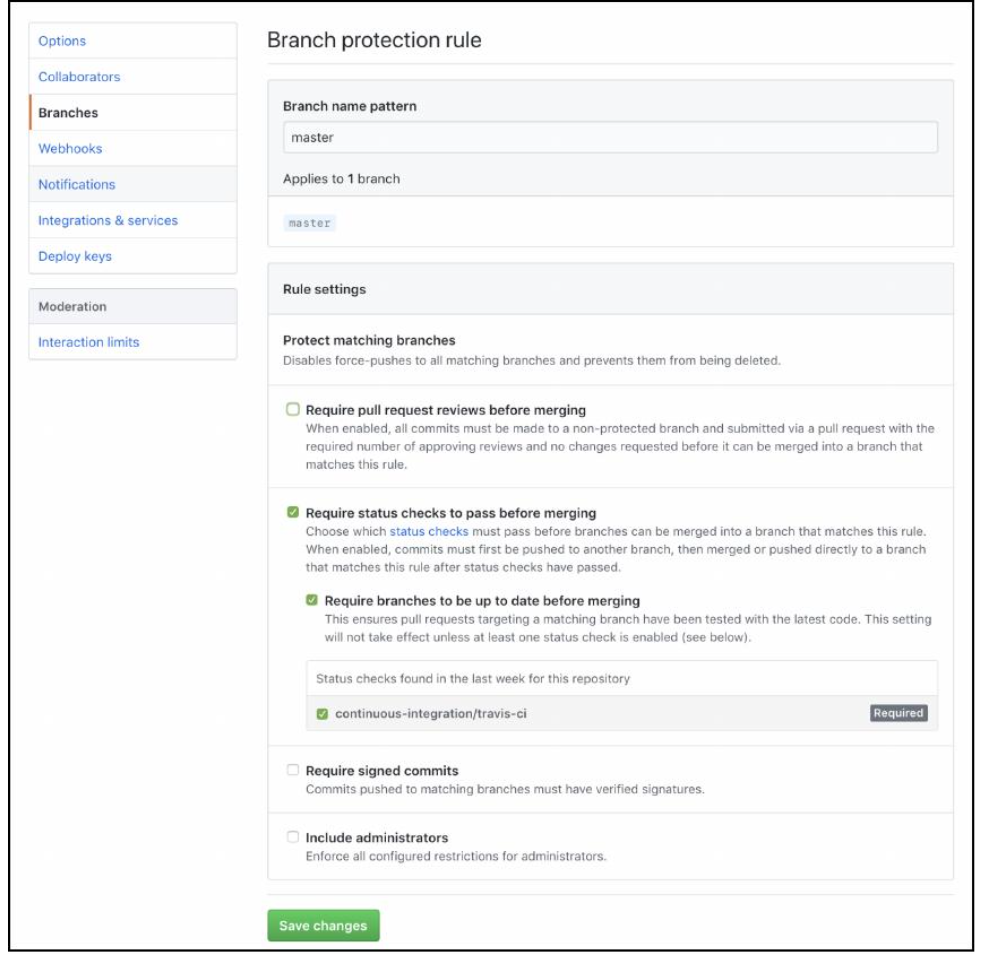


3. Nous sélectionnons également l'option (Require branches to be up to date before merging) Exiger que les branches soient à jour avant de fusionner. Cela garantit qu'il n'y a pas de fusions dans la master qui n'ont pas été exécutées auparavant.


    Jetez un œil aux autres possibilités offertes par GitHub. En particulier,
    l'application des revues de code est conseillée pour faire du code à revoir
    avant d'être fusionné et de diffuser les connaissances.

* 4. Après avoir créé une nouvelle branche et une nouvelle pull request conçue pour échouer aux tests statiques, nous pouvons voir comment les tests sont ajoutés à GitHub

## Transférer des images Docker à partir de Travis CI

Une fois que notre build a créé une image Docker, nous devons pouvoir la partager avec le reste de l'équipe ou la déployer. Nous utiliserons le registre Docker dans Docker Hub, comme expliqué dans le guide précédent, pour pousser les images. Commençons par définir les variables secrètes

## Définir les variables secrètes 

Pour pouvoir pousser vers le référentiel Docker, nous devons d'abord configurer un mot de passe pour se connecter au registre Docker. Cela doit être fait via la configuration des secrets dans Travis CI, pour éviter de commettre des informations sensibles dans le référentiel GitHub


    Cela vaut la peine de le répéter : ne commettez pas de secrets dans votre
    dépôt GitHub. Ces techniques peuvent être utilisées pour tout autre secret
    requis.

* 1. Installez la ligne de commande travis à l'aide de gem. Cela suppose que gem est installé sur votre système (Ruby 1.93 ou version ultérieure). Si vous ne le faites pas, vérifiez les instructions d'installation (https://github.com/travis-ci/travis.rb#installation)


    $ gem install travis

* 2. Connectez-vous à Travis :

    
    travis login --pro

* 3. Créez une variable sécurisée avec le nom d'utilisateur Docker Hub :

    $ travis encrypt --com DOCKER_USERNAME="<your user name>"

* 4. Vous verrez une sortie semblable à la suivante :


    secure: ".... encrypted data ...."

* 5. Ensuite, vous devez ajouter les données chiffrées aux variables d'environnement, comme suit :


    env:  
    global:    
      - DOCKER_COMPOSE_VERSION=1.23.2    
      - secure: ".... encrypted data ...."

* 6. Maintenant, notez la nouvelle section globale et répétez l'étape 3 avec le Docker Hub password :


    $ travis encrypt --com DOCKER_PASSWORD="<password>"

* 7. Ajoutez une autre variable sécurisée, après la première :


    env:  
      global:    
        - DOCKER_COMPOSE_VERSION=1.23.2    
        - secure: ".... encrypted data ...."    
        - secure: ".... encrypted data ...."

Cette opération crée deux variables d'environnement, disponibles lors des builds. Ne vous inquiétez pas, ils ne seront pas affichés dans les journaux :



Setting environment variables from .travis.yml

    $ export DOCKER_COMPOSE_VERSION=1.23.2
    $ export DOCKER_PASSWORD=[secure]
    $ export DOCKER_USERNAME=[secure]

Nous pouvons maintenant ajouter la commande de connexion appropriée dans la section before_install afin que le service Docker puisse se connecter et envoyer des images :




    before_install:
      ...
      - echo "Login into Docker Hub"
      - echo "$DOCKER_PASSWORD" | docker login -u "$DOCKER_USERNAME" --password-stdin


L'étape suivante consiste à créer et marquer l'image résultante

## tagging et pushing des builds

Le code suivant ajoutera une nouvelle étape qui construira, balisera et enfin poussera le résultat vers le registre Docker


    jobs:
          ...
        - stage: push
          script:
          - cd ch4
          - docker-compose build server
          - docker tag thoughts_server:latest <registry>/thoughts-backend:$TRAVIS_BRANCH

Cette première partie construit l'image finale du serveur et la balise avec le nom de la branche. Pour la déployer, nous allons ajouter une section deploy :



    - stage: push  
    script:  
      ...  
      - docker tag thoughts_server:latest <registry>/thoughts-backend:$TRAVIS_BRANCH  
      deploy:  
      - provider: script    
        script: docker push <registry>/thoughts-backend:$TRAVIS_BRANCH    
        on:      
          branch: master

La section deploy exécute une commande de script lorsque la branche est master. Maintenant, notre build générera également une image finale et la poussera. Cela garantira que notre registre obtient la dernière version dans notre branche principale.


Nous pouvons ajouter plus de conditions de déploiement pour pousser la balise ; par exemple, si nous créons un nouveau Git tag, nous pouvons pousser l'image résultante avec la balise appropriée.


Nous pouvons ajouter les tag à la section de déploiement :



    deploy:
          - provider: script
            script: docker push <registry>/thoughts-backend:$TRAVIS_BRANCH
            on:
              branch: master        
          - provider: script
            script: docker push <registry>/thoughts-backend:$TRAVIS_TAG
            on:
              tags: True

Vous pouvez consulter la documentation complète du déploiement ici : https://docs.travis-ci.com/user/deployment. Nous avons couvert le fournisseur de script, qui est un moyen de créer nos propres commandes, mais offre une prise en charge de fournisseurs tels que Heroku, PyPI (dans le cas de la création d'un package Python) et AWS S3

## Tagging et pousser chaque commit 

Il est possible de pousser chaque image construite vers le registre, identifié par son Git SHA. Cela peut être utile lorsque le travail en cours peut être partagé à des fins de démonstration, de tests, etc.


Pour ce faire, nous devons créer une variable d'environnement avec le Git SHA dans la section before_install 


    before_install:  
        ...  
        - export GIT_SHA=`git rev-parse --short HEAD`  
        - echo "Building commit $GIT_SHA"

La section push ajoute ensuite la balise et le push de l'image :



    - stage: push  
        script:  
        - cd Chapter04  
        - docker-compose build server  
        - docker tag thoughts_server:latest <registry>/thoughts-backend:$GIT_SHA  
        - docker push <registry>/thoughts-backend:$GIT_SHA  
        - docker tag thoughts_server:latest <registry>/thoughts-backend:$TRAVIS_BRANCH

Comme cette action se produit avant la partie de déploiement, elle sera produite sur chaque build qui atteint cette section.

Veuillez noter que le registre doit être adapté à vos propres détails de registre. Si vous clonez l'exemple de référentiel, ce dernier devra être modifié.


## Résumé

Dans ce guide, nous avons présenté les pratiques d'intégration continue et exploré comment Docker aide à les mettre en œuvre. Nous avons également examiné comment concevoir un pipeline qui garantit que notre code respecte toujours des normes élevées et détecte les écarts dès que possible. 


L'utilisation de Gitbranches et de demandes d'extraction dans GitHub joue avec cela, car nous pouvons déterminer quand le code est prêt à être fusionné dans la branche principale et déployé. 

Nous avons ensuite présenté Travis CI comme un excellent outil avec lequel travailler avec GitHub pour réaliser une intégration continue, et discuté ses caractéristiques. Nous avons appris comment créer un pipeline dans Travis CI, à partir de la création du fichier .travis.yml, comment configurer des tâches, comment faire en sorte que la construction envoie une image Docker validée à notre registre Docker et comment être notifié. accélérer les sections en cours d'exécution en parallèle, ainsi que la façon de définir des valeurs assecrets. Nous avons également configuré GitHub pour nous assurer que le pipeline Travis CI s'est exécuté avec succès avant de fusionner le nouveau code dans notre branche principale